In [2]:
 """
 Author: Silky Mishra
 Dataset link : http://archive.ics.uci.edu/ml/datasets/online+retail
 Source : UCI ML Repository
 """

 #Download dataset into local environment
 !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

--2021-07-16 03:13:42--  http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  6.09MB/s    in 3.7s    

2021-07-16 03:13:46 (6.09 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

In [4]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [6]:
data['Date'] = data['InvoiceDate'].dt.date
data['Time'] = data['InvoiceDate'].dt.time
data['Hour'] = data['InvoiceDate'].dt.hour

In [7]:
data.shape

(541909, 11)

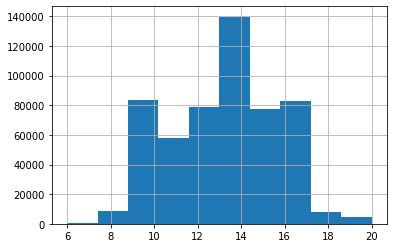

In [8]:
#Analyze the most frequent hours
data['Hour'].hist()

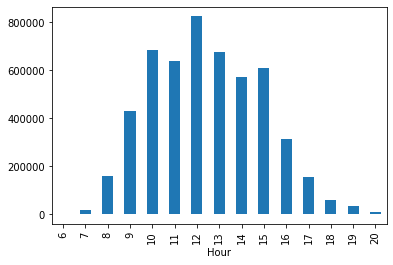

In [9]:
#hour-wise volume mapping
data.groupby(['Hour'])['Quantity'].sum().plot(kind='bar')

There is a clear spike in volume of orders between 10am to 3pm

In [10]:
#How many items each customer buy?
df = data.groupby(['InvoiceNo'])['Quantity'].sum()
df

InvoiceNo
536365        40
536366        12
536367        83
536368        15
536369         3
           ...  
C581484   -80995
C581490      -23
C581499       -1
C581568       -5
C581569       -6
Name: Quantity, Length: 25900, dtype: int64

In [11]:
df = df.reset_index()

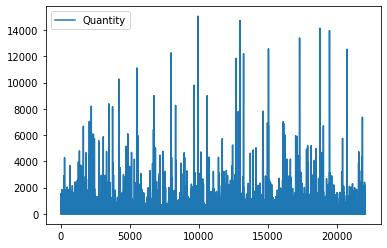

In [12]:
df.loc[(df['Quantity']>0) & (df['Quantity']<20000)].plot()

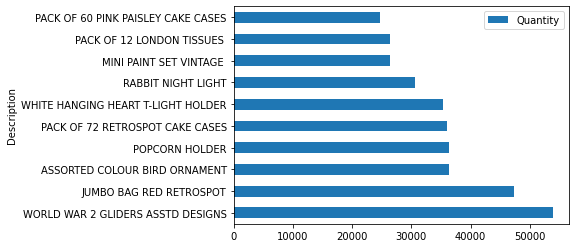

In [13]:
#Top 10 bestsellers
topTen = data.groupby(['Description'])['Quantity'].sum()
topTen = topTen.reset_index()
topTen = topTen.sort_values('Quantity', ascending=False).head(10)
topTen.plot(kind='barh', x='Description', y='Quantity')

In [14]:
#Which items are brought together?
combined_items = data[data['Quantity']>0].groupby(['InvoiceNo']).apply(lambda x: ('| '.join(map(str,x['Description']))))
combined_items.head()

InvoiceNo
536365    WHITE HANGING HEART T-LIGHT HOLDER| WHITE META...
536366    HAND WARMER UNION JACK| HAND WARMER RED POLKA DOT
536367    ASSORTED COLOUR BIRD ORNAMENT| POPPY'S PLAYHOU...
536368    JAM MAKING SET WITH JARS| RED COAT RACK PARIS ...
536369                             BATH BUILDING BLOCK WORD
dtype: object

In [15]:
combined_items = combined_items.reset_index()
combined_items.head()

,InvoiceNo,0
0,536365,WHITE HANGING HEART T-LIGHT HOLDER| WHITE META...
1,536366,HAND WARMER UNION JACK| HAND WARMER RED POLKA DOT
2,536367,ASSORTED COLOUR BIRD ORNAMENT| POPPY'S PLAYHOU...
3,536368,JAM MAKING SET WITH JARS| RED COAT RACK PARIS ...
4,536369,BATH BUILDING BLOCK WORD


In [16]:
combined_items.iloc[:,1].str.split('|', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113
0,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,ASSORTED COLOUR BIRD ORNAMENT,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE KITCHEN,FELTCRAFT PRINCESS CHARLOTTE DOLL,IVORY KNITTED MUG COSY,BOX OF 6 ASSORTED COLOUR TEASPOONS,BOX OF VINTAGE JIGSAW BLOCKS,BOX OF VINTAGE ALPHABET BLOCKS,HOME BUILDING BLOCK WORD,LOVE BUILDING BLOCK WORD,RECIPE BOX WITH METAL HEART,DOORMAT NEW ENGLAND,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,JAM MAKING SET WITH JARS,RED COAT RACK PARIS FASHION,YELLOW COAT RACK PARIS FASHION,BLUE COAT RACK PARIS FASHION,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,BATH BUILDING BLOCK WORD,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20723,LARGE CAKE STAND HANGING STRAWBERY,SET OF 3 HANGING OWLS OLLIE BEAK,RED RETROSPOT ROUND CAKE TINS,DOORMAT RED RETROSPOT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
20724,CIRCUS PARADE LUNCH BOX,PLASTERS IN TIN CIRCUS PARADE,PLASTERS IN TIN STRONGMAN,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,CHILDRENS APRON SPACE

In [17]:
basket = (data[data['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [18]:
basket

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,...,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [20]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
#basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [22]:
basket_sets.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

# Reminder: 
1. **Support** indicates freuquency with which 2 items show up together in a transaction \
2. **Confidence** indicates how much confidence can we have of a particular association rule holding true [ex: for retail, a confidence >0.5 is good for us to proceed with recommendations of associated products] \
3. **Lift** indicates the ratio of observed support to support expected if the 2 items were independent of each other. \
* If lift < 1, 1 item is a substitute of the other
* If lift = 1, the 2 items are independent. No rule can be derived from this association
* If life > 1, lift will inform on the degree of dependency between the 2 items. 



In [23]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.143167,0.117137,0.075922,0.530303,4.527217,0.059152,1.879645
1,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.117137,0.143167,0.075922,0.648148,4.527217,0.059152,2.435209
2,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.143167,0.145336,0.086768,0.606061,4.170059,0.065961,2.169531
3,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.145336,0.143167,0.086768,0.597015,4.170059,0.065961,2.126215
4,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.117137,0.145336,0.088937,0.759259,5.224157,0.071913,3.550142


This data is now ready to be used by analysts to derive insights relevant for them. Sample inferences can be:


1.   What are the items with lift value >6 and <9?
2.   Does the data make sense? (ex: is the association between bananas and alarm clock or between 2 different types of clocks or between cups and paper plates)
3.  Based on the confidence, who are the users who can be targeted buying A but not B? In other words, identify the target audience for item B.
4. Why are they buying A and not B? You can analyse total cart values, days/hours of shopping activity and determine the possible cause
5. What are the promotion strategies that can be rolled out based on this RCA?

Once the promotional strategies are rolled out, re-calculate the support, confidence and lift.
OR
re-analyze the sales growth of item B. 

Did it grow? By what % did it grow?
If the % growth is +ve, re-compute the support, lift and confidence and repeat the practice for other items (C,D,E,F, etc)


